# TACOS Tutorial: Thermodynamic Bounds for Chemical Reaction Networks

This notebook demonstrates how to use **TACOS** (**T**hermodynamic space for **A**ccessible **C**oncentrations of **O**ut-of-equilibrium **S**tationary chemical reaction networks) to compute fundamental thermodynamic bounds on chemical reaction networks.

**Paper**: Liang, De Los Rios, Busiello. *Thermodynamic Space of Chemical Reaction Networks*. [arXiv:2407.11498](https://arxiv.org/abs/2407.11498)

---

## Table of Contents

1. [Setup](#1-setup)
2. [Defining a Chemical Reaction Network](#2-defining-a-chemical-reaction-network)
3. [Running the Analysis Pipeline](#3-running-the-analysis-pipeline)
4. [Understanding the Results](#4-understanding-the-results)
5. [Visualizing Affinity Bounds](#5-visualizing-affinity-bounds)
6. [Visualizing Concentration Bounds](#6-visualizing-concentration-bounds)
7. [Validation with Simulations](#7-validation-with-simulations)
8. [Chemical Probes](#8-chemical-probes)

## 1. Setup

First, let's import the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TACOS imports
from crn_bounds.api import CRNInput, run_pipeline

# For visualization
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Color palette
COLORS = {
    'fill': '#e8f5e9',
    'upper': '#c0392b',
    'lower': '#2980b9',
    'eq': '#27ae60',
    'scatter': '#34495e',
}

## 2. Defining a Chemical Reaction Network

### Example: Fuel-Driven Self-Assembly

We'll use a simple self-assembly network where monomers assemble into a trimer, driven by fuel consumption:

$$
\begin{align}
\text{R1:} \quad F + 2A &\rightleftharpoons B + W \quad \text{(fuel-driven dimerization)} \\
\text{R2:} \quad A + B &\rightleftharpoons C \quad \text{(trimerization)} \\
\text{R3:} \quad C &\rightleftharpoons 3A \quad \text{(disassembly)}
\end{align}
$$

where:
- $A$ = monomer, $B$ = dimer, $C$ = trimer (internal species)
- $F$ = fuel, $W$ = waste (external chemostats)

In [2]:
# Internal stoichiometry matrix: (n_species × n_reactions)
# Entry S[i,ρ] = net change in species i when reaction ρ proceeds once
Sx = np.array([
    [-2, -1,  3],  # A: consumed in R1,R2; produced in R3
    [ 1, -1,  0],  # B: produced in R1; consumed in R2
    [ 0,  1, -1],  # C: produced in R2; consumed in R3
], dtype=float)

# Standard chemical potentials (dimensionless: μ⁰/RT)
mu0_X = np.array([0.0, 0.0, 0.0])

# External driving: Δμ/RT = 2.0 on reaction R1 (fuel hydrolysis)
delta_mu = 2.0
A_Y = np.array([delta_mu, 0.0, 0.0])

# Species names for display
species_names = ['A', 'B', 'C']

print("Stoichiometry Matrix Sx:")
print(Sx)
print(f"\nDriving: Δμ/RT = {delta_mu}")

Stoichiometry Matrix Sx:
[[-2. -1.  3.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]]

Driving: Δμ/RT = 2.0


## 3. Running the Analysis Pipeline

The `run_pipeline()` function performs the complete thermodynamic analysis:
1. Splits reversible reactions into forward/backward pairs
2. Enumerates Elementary Flux Modes (EFMs)
3. Computes affinity bounds for each reaction
4. Computes concentration log-ratio bounds

In [3]:
# Create input and run pipeline
crn_input = CRNInput(Sx=Sx, mu0_X=mu0_X, A_Y=A_Y)
result = run_pipeline(crn_input)

print(f"Found {len(result.efms_orig)} Elementary Flux Mode(s)")

Found 1 Elementary Flux Mode(s)


## 4. Understanding the Results

### 4.1 Elementary Flux Modes (EFMs)

EFMs are the minimal steady-state flux patterns — ways the network can cycle without net accumulation of internal species.

In [4]:
print("Elementary Flux Modes:")
for i, efm in enumerate(result.efms_orig):
    # Normalize for display
    efm_norm = efm / efm[0] if efm[0] != 0 else efm
    print(f"  EFM {i+1}: {efm_norm}")
    print(f"          → All reactions participate equally in one cycle")

Elementary Flux Modes:
  EFM 1: [1. 1. 1.]
          → All reactions participate equally in one cycle


### 4.2 Affinity Bounds

From paper Eq. (20): The steady-state affinity of each reaction is bounded by cycle affinities.

In [5]:
print("Affinity Bounds (A/RT):")
print("=" * 45)
for i, ab in enumerate(result.affinity_bounds):
    print(f"  R{i+1}: A ∈ [{ab.lower:.3f}, {ab.upper:.3f}]  (width = {ab.upper - ab.lower:.3f})")

Affinity Bounds (A/RT):
  R1: A ∈ [0.000, 2.000]  (width = 2.000)
  R2: A ∈ [0.000, 2.000]  (width = 2.000)
  R3: A ∈ [0.000, 2.000]  (width = 2.000)


### 4.3 Concentration Bounds

The concentration log-ratio bounds constrain products of steady-state concentrations:
$$l_\rho \leq \mathbf{s}^T \ln \mathbf{x}^{\text{ss}} \leq u_\rho$$

In [6]:
def format_log_ratio(s, names):
    """Format stoichiometry as log-ratio expression."""
    terms = []
    for coef, name in zip(s, names):
        if abs(coef) < 1e-10:
            continue
        if coef == 1:
            terms.append(f"ln({name})")
        elif coef == -1:
            terms.append(f"-ln({name})")
        elif coef > 0:
            terms.append(f"{int(coef)}ln({name})")
        else:
            terms.append(f"{int(coef)}ln({name})")
    return " + ".join(terms).replace("+ -", "- ")

print("Concentration Log-Ratio Bounds:")
print("=" * 60)
for i, lb in enumerate(result.reaction_log_bounds):
    expr = format_log_ratio(lb.s, species_names)
    print(f"  R{i+1}: {lb.lo:+.3f} ≤ {expr} ≤ {lb.hi:+.3f}")

Concentration Log-Ratio Bounds:
  R1: -0.000 ≤ -2ln(A) + ln(B) ≤ +2.000
  R2: -2.000 ≤ -ln(A) - ln(B) + ln(C) ≤ -0.000
  R3: +0.000 ≤ -3ln(A) + ln(C) ≤ +2.000


## 5. Visualizing Affinity Bounds

The thermodynamic space constrains each reaction's affinity to lie within computed bounds.

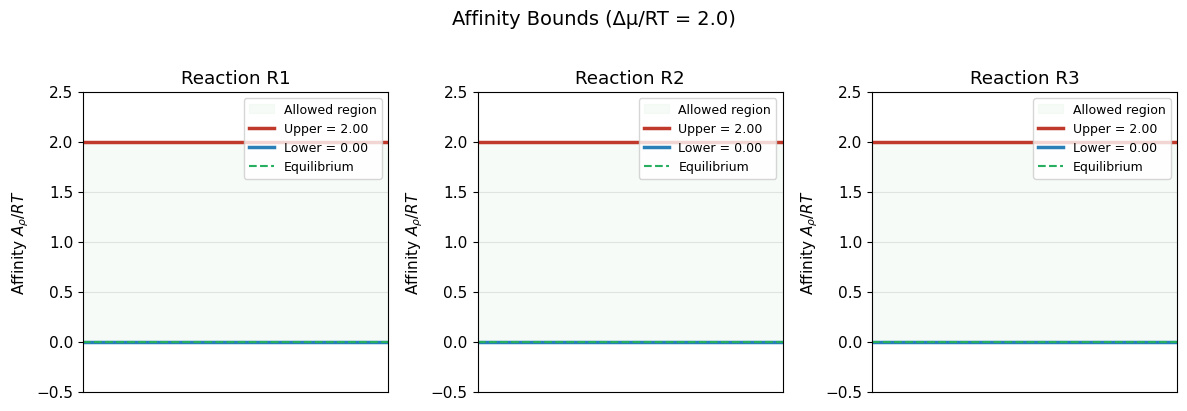

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    ab = result.affinity_bounds[i]
    
    # Draw thermodynamic space
    ax.axhspan(ab.lower, ab.upper, alpha=0.35, color=COLORS['fill'], label='Allowed region')
    ax.axhline(ab.upper, color=COLORS['upper'], lw=2.5, label=f'Upper = {ab.upper:.2f}')
    ax.axhline(ab.lower, color=COLORS['lower'], lw=2.5, label=f'Lower = {ab.lower:.2f}')
    ax.axhline(0, color=COLORS['eq'], lw=1.5, ls='--', label='Equilibrium')
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, delta_mu + 0.5)
    ax.set_ylabel(r'Affinity $A_\rho / RT$')
    ax.set_title(f'Reaction R{i+1}')
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Affinity Bounds (Δμ/RT = {delta_mu})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Visualizing Concentration Bounds

The concentration bounds define the accessible region in log-concentration space.

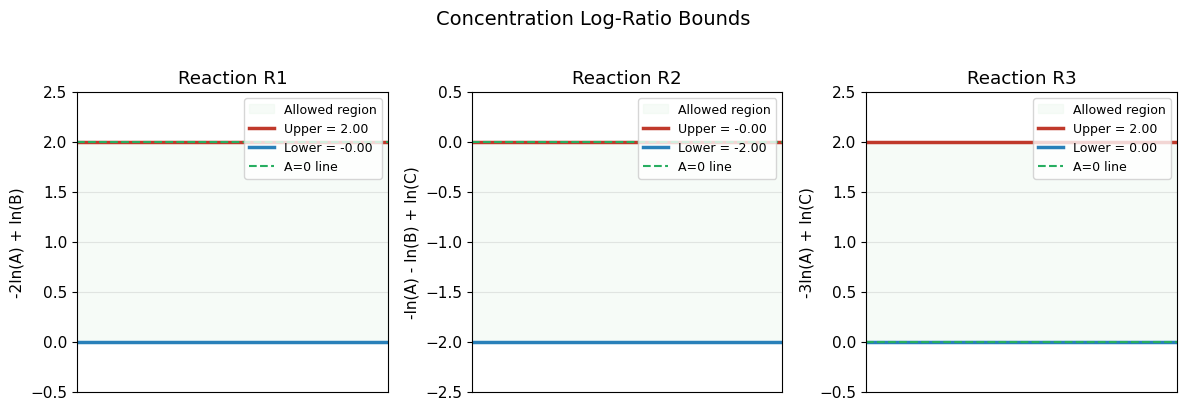

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    lb = result.reaction_log_bounds[i]
    
    # Draw concentration bounds
    ax.axhspan(lb.lo, lb.hi, alpha=0.35, color=COLORS['fill'], label='Allowed region')
    ax.axhline(lb.hi, color=COLORS['upper'], lw=2.5, label=f'Upper = {lb.hi:.2f}')
    ax.axhline(lb.lo, color=COLORS['lower'], lw=2.5, label=f'Lower = {lb.lo:.2f}')
    
    # Equilibrium line (where A=0, so s·ln(x) = -ΔG⁰ + A_Y)
    s = lb.s
    dG0 = float(s @ mu0_X)
    eq_val = -dG0 + A_Y[i]
    ax.axhline(eq_val, color=COLORS['eq'], lw=1.5, ls='--', label=f'A=0 line')
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(lb.lo - 0.5, lb.hi + 0.5)
    ax.set_ylabel(f'{format_log_ratio(lb.s, species_names)}')
    ax.set_title(f'Reaction R{i+1}')
    ax.set_xticks([])
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Concentration Log-Ratio Bounds', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 7. Validation with Simulations

Let's validate the bounds by sampling steady states with random kinetics satisfying **Local Detailed Balance (LDB)**.

In [9]:
from crn_bounds.self_assembly import self_assembly_crn
from crn_bounds.ldb import sample_rates_from_ldb
from crn_bounds.model import relaxation

# Get mass-action CRN model
crn = self_assembly_crn()

# External species: [F, W] = [1, 1]
y_ext = np.array([1.0, 1.0])

# Chemical potentials for external species (μ_F - μ_W = Δμ = 2.0)
mu_Y = np.array([1.0, -1.0])

# Sample steady states
n_samples = 300
rng = np.random.default_rng(42)

steady_states = []
affinities_list = []
log_ratios_list = []

for _ in range(n_samples):
    # Sample LDB-consistent rate constants
    kp, km = sample_rates_from_ldb(crn, mu0_X, mu_Y, rng=rng, loga_range=(-2.0, 2.0))
    
    # Random initial conditions
    x0 = np.exp(rng.uniform(-1, 2, size=3))
    
    try:
        x_ss = relaxation(crn, kp, km, y=y_ext, x0=x0, t_final=500.0)
        
        if np.all(x_ss > 1e-12):
            steady_states.append(x_ss)
            
            # Compute affinities and log-ratios
            affinities = []
            log_ratios = []
            for rho in range(3):
                s = Sx[:, rho]
                A = -s @ mu0_X - s @ np.log(x_ss) + A_Y[rho]
                affinities.append(A)
                log_ratios.append(s @ np.log(x_ss))
            affinities_list.append(affinities)
            log_ratios_list.append(log_ratios)
    except RuntimeError:
        pass

affinities_arr = np.array(affinities_list)
log_ratios_arr = np.array(log_ratios_list)

print(f"Successfully sampled {len(affinities_arr)} steady states")

Successfully sampled 300 steady states


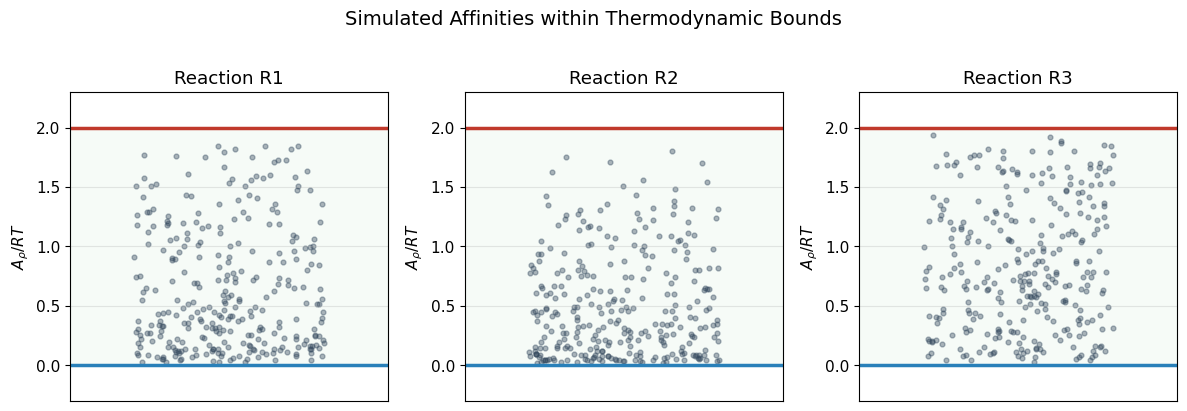

Affinity Bound Validation:
  R1: 0 violations out of 300 samples ✓
  R2: 0 violations out of 300 samples ✓
  R3: 0 violations out of 300 samples ✓


In [10]:
# Visualize: Affinity bounds with simulated data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    ab = result.affinity_bounds[i]
    
    # Draw bounds
    ax.axhspan(ab.lower, ab.upper, alpha=0.35, color=COLORS['fill'])
    ax.axhline(ab.upper, color=COLORS['upper'], lw=2.5)
    ax.axhline(ab.lower, color=COLORS['lower'], lw=2.5)
    
    # Scatter simulated affinities
    x_jitter = rng.uniform(-0.3, 0.3, size=len(affinities_arr))
    ax.scatter(x_jitter, affinities_arr[:, i], alpha=0.4, s=12, c=COLORS['scatter'])
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.3, delta_mu + 0.3)
    ax.set_ylabel(r'$A_\rho / RT$')
    ax.set_title(f'Reaction R{i+1}')
    ax.set_xticks([])
    ax.grid(True, alpha=0.3)

plt.suptitle('Simulated Affinities within Thermodynamic Bounds', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Check for violations
print("Affinity Bound Validation:")
for i in range(3):
    ab = result.affinity_bounds[i]
    violations = np.sum((affinities_arr[:, i] < ab.lower - 1e-6) | 
                       (affinities_arr[:, i] > ab.upper + 1e-6))
    print(f"  R{i+1}: {violations} violations out of {len(affinities_arr)} samples ✓" if violations == 0 else f"  R{i+1}: {violations} violations!")

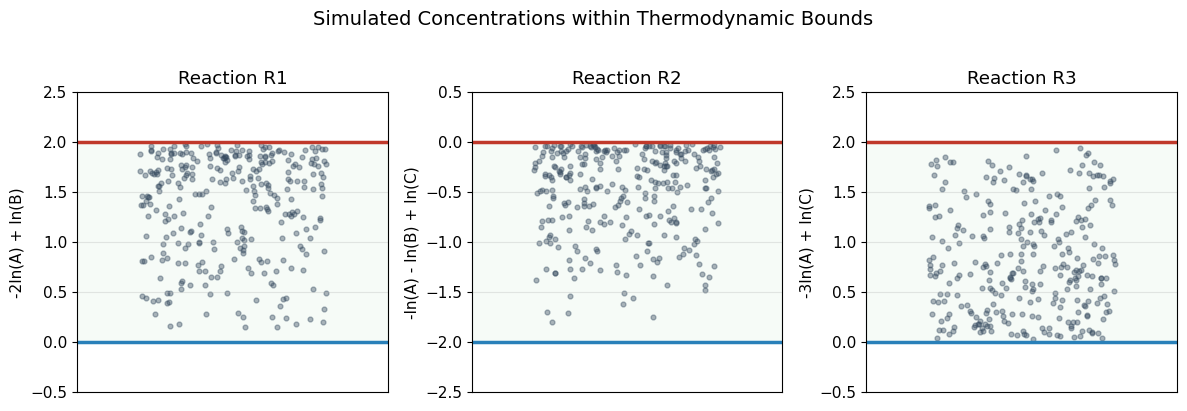

Concentration Bound Validation:
  R1: 0 violations out of 300 samples ✓
  R2: 0 violations out of 300 samples ✓
  R3: 0 violations out of 300 samples ✓


In [11]:
# Visualize: Concentration bounds with simulated data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    lb = result.reaction_log_bounds[i]
    
    # Draw bounds
    ax.axhspan(lb.lo, lb.hi, alpha=0.35, color=COLORS['fill'])
    ax.axhline(lb.hi, color=COLORS['upper'], lw=2.5)
    ax.axhline(lb.lo, color=COLORS['lower'], lw=2.5)
    
    # Compute log-ratio for this reaction's stoichiometry
    s = lb.s
    simulated_lr = np.array([s @ np.log(x) for x in steady_states])
    
    # Scatter simulated log-ratios
    x_jitter = rng.uniform(-0.3, 0.3, size=len(simulated_lr))
    ax.scatter(x_jitter, simulated_lr, alpha=0.4, s=12, c=COLORS['scatter'])
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(lb.lo - 0.5, lb.hi + 0.5)
    ax.set_ylabel(f'{format_log_ratio(s, species_names)}')
    ax.set_title(f'Reaction R{i+1}')
    ax.set_xticks([])
    ax.grid(True, alpha=0.3)

plt.suptitle('Simulated Concentrations within Thermodynamic Bounds', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Check for violations
print("Concentration Bound Validation:")
for i in range(3):
    lb = result.reaction_log_bounds[i]
    s = lb.s
    simulated_lr = np.array([s @ np.log(x) for x in steady_states])
    violations = np.sum((simulated_lr < lb.lo - 1e-6) | (simulated_lr > lb.hi + 1e-6))
    print(f"  R{i+1}: {violations} violations out of {len(steady_states)} samples ✓" if violations == 0 else f"  R{i+1}: {violations} violations!")

## 8. Chemical Probes

**Chemical probes** are virtual reactions not in the original network but compatible with conservation laws. They allow bounding concentration ratios that span multiple reactions.

Let's run the pipeline with automatic probe detection:

In [12]:
# Run pipeline with auto-probe detection
result_probes = run_pipeline(crn_input, auto_probes=True, probe_coeff_bound=3, max_probes=10)

print(f"Found {len(result_probes.probes)} chemical probes")

Found 10 chemical probes


In [13]:
# Display probe information
print("Chemical Probe Analysis:")
print("=" * 70)

for i, pr in enumerate(result_probes.probes[:5]):  # Show first 5 probes
    # Format as reaction
    reactants = [f"{int(c)}{species_names[j]}" if c > 1 else species_names[j] 
                 for j, c in enumerate(pr.probe_sx) if c > 0]
    products = [f"{int(-c)}{species_names[j]}" if c < -1 else species_names[j] 
                for j, c in enumerate(pr.probe_sx) if c < 0]
    
    rxn_str = " + ".join(reactants) + " ⇌ " + " + ".join(products)
    
    print(f"\nProbe {i+1}: {rxn_str}")
    print(f"  Stoichiometry: {pr.probe_sx}")
    print(f"  Affinity bound:     [{pr.affinity_bound.lower:+.3f}, {pr.affinity_bound.upper:+.3f}]")
    print(f"  Log-ratio bound:    [{pr.log_ratio_bound.lo:+.3f}, {pr.log_ratio_bound.hi:+.3f}]")

Chemical Probe Analysis:

Probe 1: 5A ⇌ B + C
  Stoichiometry: [ 5 -1 -1]
  Affinity bound:     [-0.000, +4.000]
  Log-ratio bound:    [+0.000, +4.000]

Probe 2: 8A ⇌ B + 2C
  Stoichiometry: [ 8 -1 -2]
  Affinity bound:     [-0.000, +6.000]
  Log-ratio bound:    [+0.000, +6.000]

Probe 3: 11A ⇌ B + 3C
  Stoichiometry: [11 -1 -3]
  Affinity bound:     [-0.000, +8.000]
  Log-ratio bound:    [+0.000, +8.000]

Probe 4: 14A ⇌ B + 4C
  Stoichiometry: [14 -1 -4]
  Affinity bound:     [-0.000, +10.000]
  Log-ratio bound:    [+0.000, +10.000]

Probe 5: 17A ⇌ B + 5C
  Stoichiometry: [17 -1 -5]
  Affinity bound:     [-0.000, +12.000]
  Log-ratio bound:    [+0.000, +12.000]


### Visualizing Probe Bounds

Let's visualize the bounds for the most interesting probes and validate with simulations.

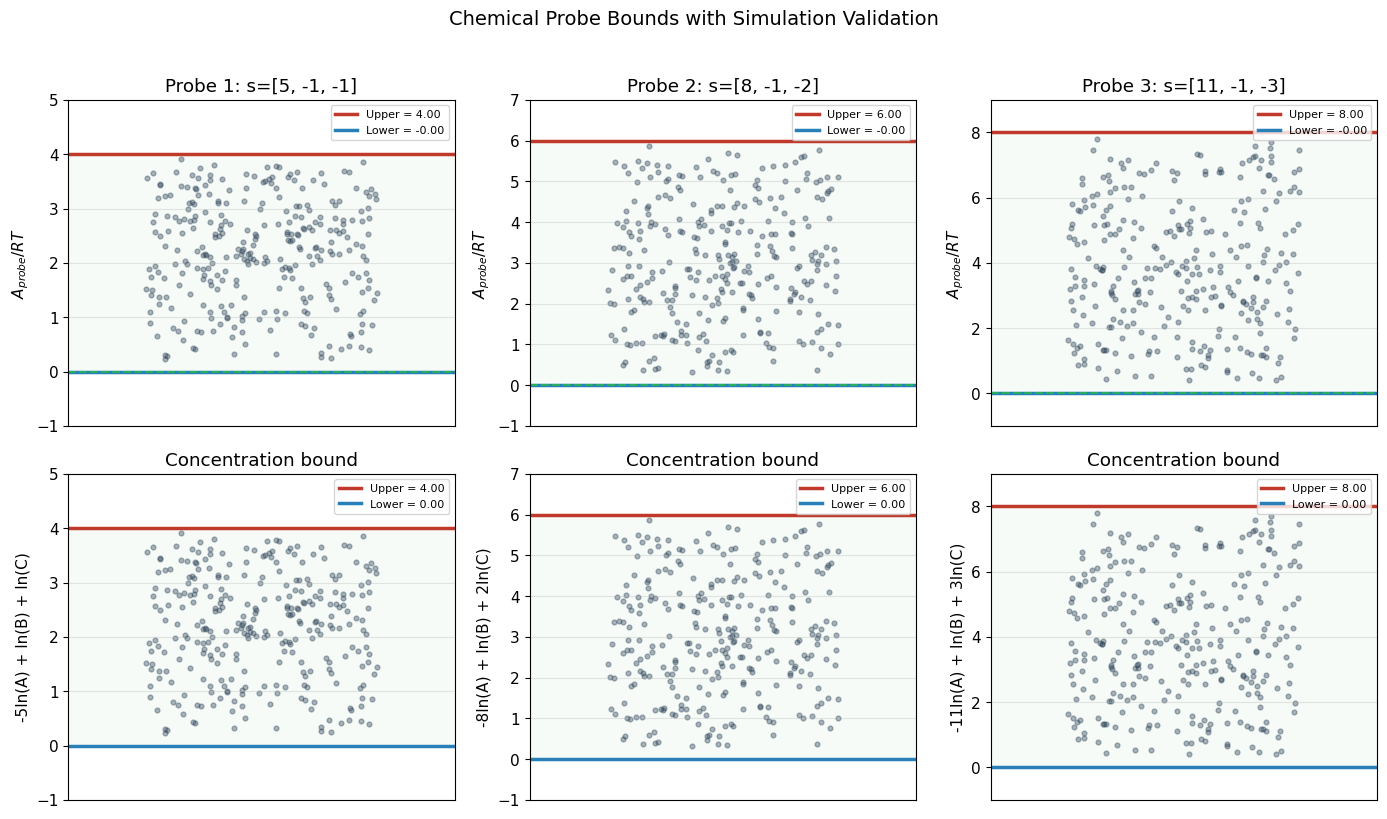

In [14]:
# Select a few interesting probes to visualize
probes_to_show = result_probes.probes[:3]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for i, pr in enumerate(probes_to_show):
    # Affinity bounds (top row)
    ax = axes[0, i]
    ab = pr.affinity_bound
    
    ax.axhspan(ab.lower, ab.upper, alpha=0.35, color=COLORS['fill'])
    ax.axhline(ab.upper, color=COLORS['upper'], lw=2.5, label=f'Upper = {ab.upper:.2f}')
    ax.axhline(ab.lower, color=COLORS['lower'], lw=2.5, label=f'Lower = {ab.lower:.2f}')
    ax.axhline(0, color=COLORS['eq'], lw=1.5, ls='--')
    
    # Simulate probe affinity
    s_probe = pr.probe_sx.astype(float)
    probe_affinities = [-s_probe @ mu0_X - s_probe @ np.log(x) for x in steady_states]
    x_jitter = rng.uniform(-0.3, 0.3, size=len(probe_affinities))
    ax.scatter(x_jitter, probe_affinities, alpha=0.4, s=12, c=COLORS['scatter'])
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(ab.lower - 1, ab.upper + 1)
    ax.set_ylabel(r'$A_{probe} / RT$')
    ax.set_title(f'Probe {i+1}: s={list(pr.probe_sx)}')
    ax.set_xticks([])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Concentration bounds (bottom row)
    ax = axes[1, i]
    lb = pr.log_ratio_bound
    
    ax.axhspan(lb.lo, lb.hi, alpha=0.35, color=COLORS['fill'])
    ax.axhline(lb.hi, color=COLORS['upper'], lw=2.5, label=f'Upper = {lb.hi:.2f}')
    ax.axhline(lb.lo, color=COLORS['lower'], lw=2.5, label=f'Lower = {lb.lo:.2f}')
    
    # Simulate log-ratio
    s = lb.s
    probe_lr = [s @ np.log(x) for x in steady_states]
    ax.scatter(x_jitter, probe_lr, alpha=0.4, s=12, c=COLORS['scatter'])
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(lb.lo - 1, lb.hi + 1)
    ax.set_ylabel(format_log_ratio(s, species_names))
    ax.set_title(f'Concentration bound')
    ax.set_xticks([])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Chemical Probe Bounds with Simulation Validation', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Validate all probe bounds
print("Probe Bound Validation:")
print("=" * 50)

for i, pr in enumerate(result_probes.probes[:5]):
    s_probe = pr.probe_sx.astype(float)
    
    # Affinity validation
    probe_affinities = np.array([-s_probe @ mu0_X - s_probe @ np.log(x) for x in steady_states])
    ab = pr.affinity_bound
    a_violations = np.sum((probe_affinities < ab.lower - 1e-6) | (probe_affinities > ab.upper + 1e-6))
    
    # Concentration validation
    s = pr.log_ratio_bound.s
    probe_lr = np.array([s @ np.log(x) for x in steady_states])
    lb = pr.log_ratio_bound
    c_violations = np.sum((probe_lr < lb.lo - 1e-6) | (probe_lr > lb.hi + 1e-6))
    
    status = "✓" if (a_violations == 0 and c_violations == 0) else "✗"
    print(f"Probe {i+1} s={list(pr.probe_sx)}: Affinity {a_violations} viol, Conc {c_violations} viol {status}")

Probe Bound Validation:
Probe 1 s=[5, -1, -1]: Affinity 0 viol, Conc 0 viol ✓
Probe 2 s=[8, -1, -2]: Affinity 0 viol, Conc 0 viol ✓
Probe 3 s=[11, -1, -3]: Affinity 0 viol, Conc 0 viol ✓
Probe 4 s=[14, -1, -4]: Affinity 0 viol, Conc 0 viol ✓
Probe 5 s=[17, -1, -5]: Affinity 0 viol, Conc 0 viol ✓


## Summary

In this tutorial, we learned how to:

1. **Define a CRN** using `CRNInput` with stoichiometry matrix, standard potentials, and external driving

2. **Run the analysis** using `run_pipeline()` to compute:
   - Elementary Flux Modes (EFMs)
   - Affinity bounds for each reaction
   - Concentration log-ratio bounds

3. **Visualize** both affinity and concentration bounds

4. **Validate** bounds with simulated steady states using LDB-consistent kinetics

5. **Analyze probes** for additional concentration constraints on species interconversions

The thermodynamic bounds computed by TACOS are **universal** — they hold regardless of kinetic rate constants, as long as the system satisfies local detailed balance.

---

**Further Reading:**
- Paper: [arXiv:2407.11498](https://arxiv.org/abs/2407.11498)
- GitHub: [https://github.com/Shiling42/TACOS](https://github.com/Shiling42/TACOS)